**기본 세팅**

In [1]:
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import warnings

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

mpl.rc('font', family='NanumGothic') # 폰트 설정
mpl.rc('axes', unicode_minus=False) # 유니코드에서 음수 부호 설정

# 차트 스타일 설정
sns.set(font="NanumGothic", rc={"axes.unicode_minus":False}, style='darkgrid')
plt.rc("figure", figsize=(10,8))

warnings.filterwarnings("ignore")

# 1. 자전거 대여 수요 예측

## 1.1 데이터 불러오기

**데이터 구조**

- datetime: 날짜 + 시간


- season: 계절  (1 = 봄, 2 = 여름, 3 = 가을, 4 = 겨울)


- holiday: 휴일여부(주말 포함 x)


- workingday: 근무여부 (주말과 휴일을 제외한 일하는 날 여부)


- weather: 날씨
    - 1: 맑음, 구름 조금, 부분 흐림
    - 2: 안개 + 흐림, 안개 + 구름, 안개 + 구름 조금, 안개
    - 3: 가벼운 눈, 가벼운 비 + 천둥 + 구름, 가벼운 비 + 구름
    - 4: 폭우 + 우박 + 천둥 + 안개, 눈 + 안개  
   
   
- temp: 온도


- atemp: 체감온도


- humidity: 습도


- windspeed: 풍속


- casual: 미등록 사용자 대여량


- registered: 등록 사용자 대여량


- count: 총 대여량

In [3]:
bike_df = pd.read_csv('./bike_train.csv')
bike_df.head(3)

# 날짜 변수 반영 ↓
# bike_df = pd.read_csv('train.csv', parse_dates = ["datetime"])

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32


In [4]:
bike_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


- 데이터는 10,886 x 12개로 이루어져 있으며 피처 변수는 datetime이 object, 나머지는 float, int형으로 이루어져 있다.


- datetime의 자료 유형 변경이 필요하다(처음 불러올 떄 반영해도 된다).


- casual + registered = count이므로 casual과 registered는 피처로 사용하지 않고 제외 한다.

In [5]:
# datetime 날짜형으로 변경
bike_df["datetime"] = bike_df["datetime"].apply(pd.to_datetime)

# datetime 나누기
bike_df["year"] = bike_df["datetime"].dt.year
bike_df["month"] = bike_df["datetime"].dt.month
bike_df["day"] = bike_df["datetime"].dt.day
bike_df["hour"] = bike_df["datetime"].dt.hour

# datetime, casual, registered 제거
col_order = bike_df.columns[-4:].to_list() + bike_df.columns[1:-7].to_list() + ["count"]
bike_df = bike_df[col_order]

bike_df.head(3)

,year,month,day,hour,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count
0,2011,1,1,0,1,0,0,1,9.84,14.395,81,0.0,16
1,2011,1,1,1,1,0,0,1,9.02,13.635,80,0.0,40
2,2011,1,1,2,1,0,0,1,9.02,13.635,80,0.0,32


## 1.2 성능 평가 함수

In [6]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# MAE, RMSE, RMSLE 반환
def evaluate_regr(y,pred):
    # MAE
    mae = mean_absolute_error(y,pred)
    
    # RMSE
    rmse = np.sqrt(mean_squared_error(y,pred))
    
    # RMSLE
    log_y = np.log1p(y)
    log_pred = np.log1p(pred)
    msle = np.mean((log_y - log_pred) ** 2)
    rmsle = np.sqrt(msle)    
    
    print(f'MAE: {mae:.3f}, RMSE: {rmse:.3f}, RMSLE: {rmsle:.3f}')

- MAE, RMSE, RMSLE를 반환하는 함수를 정의하였다.


- RMSLE를 `mean_squared_log_error`나 `np.log`로 계산할 수 있는데 이 경우 데이터 값의 크기에 따라 오버플로/언더플로 오류가 발생할 수 있다.


- `np.log1p`는 log(1+입력값)으로 `np.expm1`을 이용하면 exp(입력값-1)로서 원래의 값으로 복원 가능하다.

## 1.3 회귀 예측/평가

### 1.3.1 추가 가공 전 예측/평가

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

X_features = bike_df.drop(['count'],axis=1,inplace=False)
y_target = bike_df['count']

X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.3, random_state=0)

# LinearRegression
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
pred = lr_reg.predict(X_test)

evaluate_regr(y_test ,pred)

MAE: 105.924, RMSE: 140.900, RMSLE: 1.165


- 종속 변수 count의 단위를 생각하면 각 예측 오류값은 제법 크게 나타났다.

In [8]:
def get_top_error_data(y_test, pred, n_tops = 5):
    # 예측값, 실제값 데이터 프레임
    result_df = pd.DataFrame(y_test.values, columns=['real_count'])
    result_df['predicted_count']= np.round(pred)
    result_df['diff'] = np.abs(result_df['real_count'] - result_df['predicted_count'])
    
    # 예측값과 실제값의 차이가 큰 순서로 출력
    print(result_df.sort_values('diff', ascending=False)[:n_tops])
    
get_top_error_data(y_test,pred,n_tops=10)

      real_count  predicted_count   diff
1618         890            322.0  568.0
3151         798            241.0  557.0
966          884            327.0  557.0
412          745            194.0  551.0
2817         856            310.0  546.0
2277         813            267.0  546.0
2314         766            222.0  544.0
454          721            177.0  544.0
1003         713            171.0  542.0
2394         684            142.0  542.0


- 예측값과 실제값을 비교하면 값의 차이가 크고 이런 경우 가장 먼저 종속 변수의 분포를 확인할 필요가 있다.


- 종속 변수가 정규분포 형태를 따르지 않으면 회귀 예측 성능이 저하될 가능성이 높다.

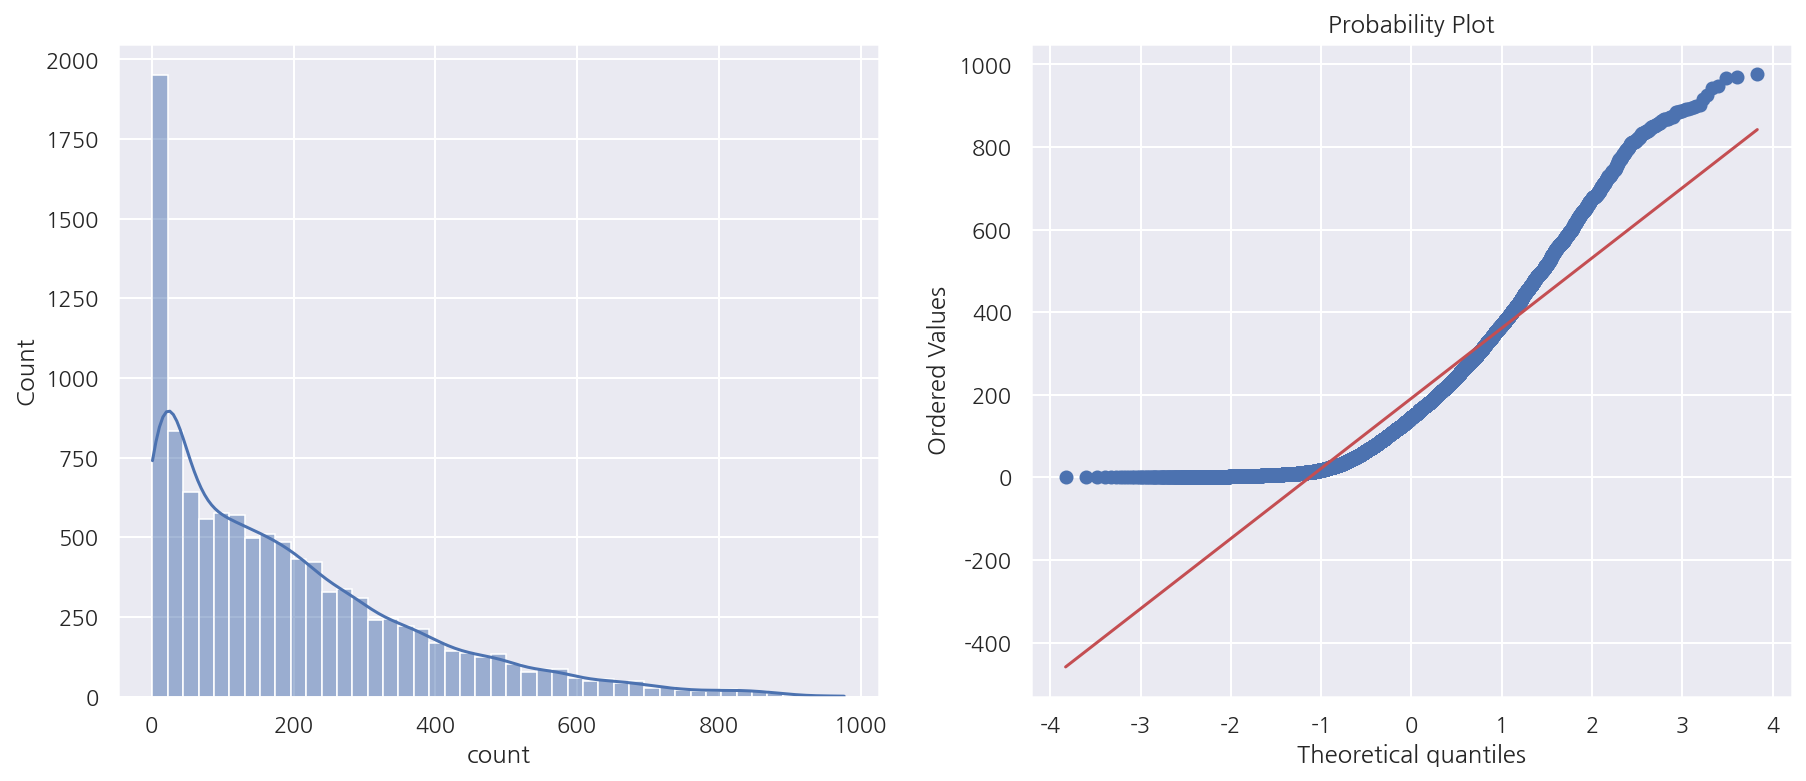

In [9]:
from scipy import stats

fig, axs = plt.subplots(1,2, figsize = (15,6))

sns.histplot(bike_df["count"], ax =axs[0], kde=True)
stats.probplot(bike_df["count"], dist='norm', fit=True, plot=axs[1])

plt.show()

- 종속 변수의 분포는 왼쪽으로 치우쳐 있다.


- Q-Q plot으로 정규분포가 아님을 한번 더 알 수 있다.


- 종속 변수를 정규분포 형태로 바꾸는 방법으로 로그 변환을 적용 해보자.

### 1.3.2 로그 변환

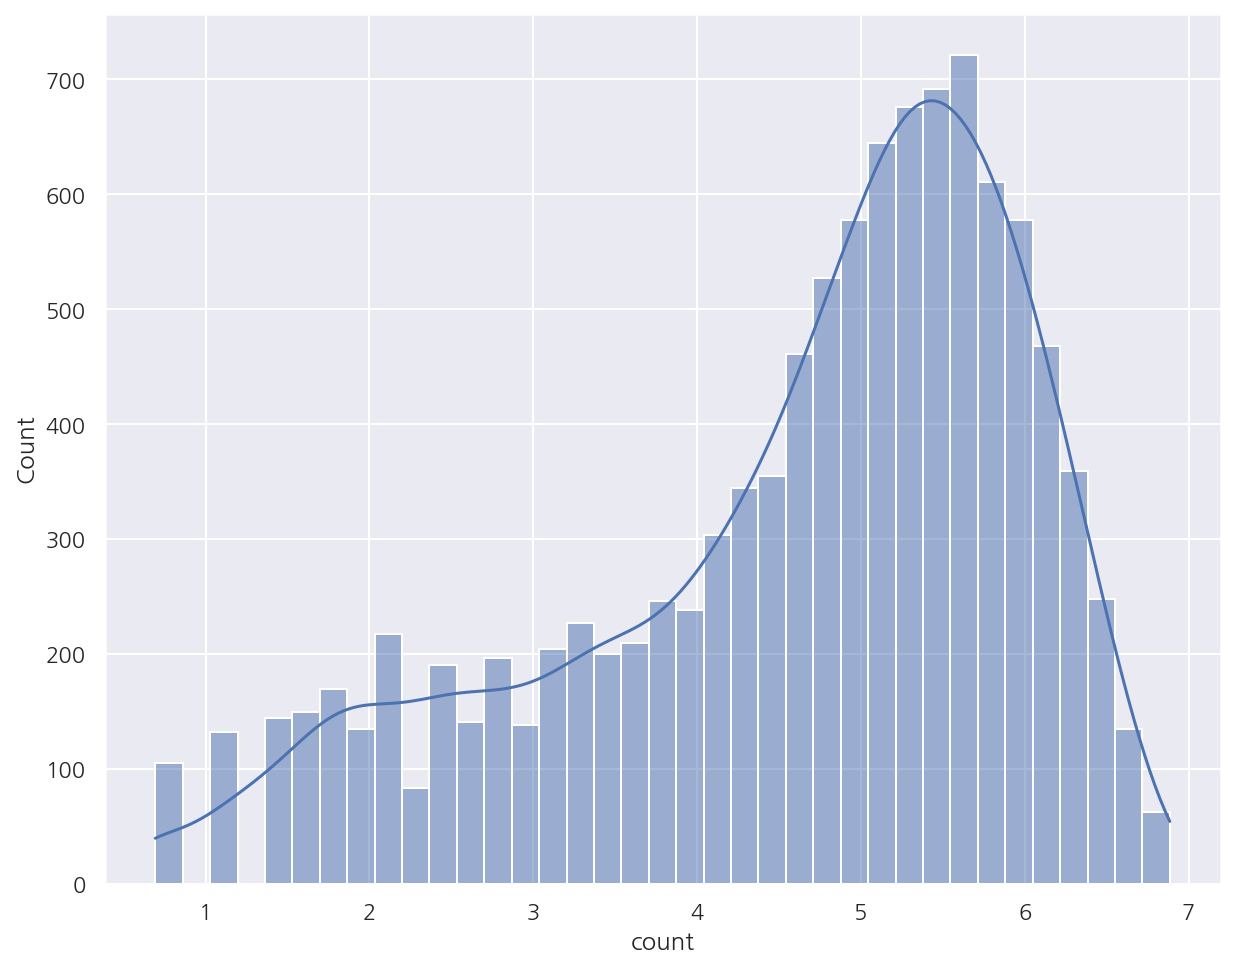

In [10]:
sns.histplot(np.log1p(bike_df["count"]), kde=True)
plt.show()

- 로그 변환 후 분포 역시 정규분포를 따른다고 보기 힘들지만 변환 전보다는 왜곡 정도가 완화되어 이대로 학습을 진행한다.

In [11]:
# target 로그 변환
y_target_log = np.log1p(y_target)
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target_log, test_size=0.3, random_state=0)

# 로그 변환 후 학습/예측
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
pred = lr_reg.predict(X_test)

# 예측값, 실제값 원래 스케일로 변환
y_test_exp = np.expm1(y_test)
pred_exp = np.expm1(pred)

evaluate_regr(y_test_exp ,pred_exp)

MAE: 109.286, RMSE: 162.594, RMSLE: 1.017


- RMSLE는 줄었지만 MAE, RMSE는 증가하였다.


- 종속 변수를 로그 변환해서 RMSLE는 그냥 RMSE로 구하면 비슷한 값일 듯 한데 원래 스케일 기준으로 모든 성능 평가 지표를 구했다.


- 이번에는 카테고리 피처에 대해 인코딩 작업을 진행해보자.

### 1.3.3 피처 인코딩

In [12]:
# 카테고리 피처 원-핫 인코딩
X_features_ohe = pd.get_dummies(X_features, columns=['year','month','hour', 'holiday','workingday','season','weather'])

X_train, X_test, y_train, y_test = train_test_split(X_features_ohe, y_target_log, test_size=0.3, random_state=0)

- 카테고리 피처에 대해 원-핫 인코딩 후 다시 train, test를 분리

In [13]:
from sklearn.linear_model import Ridge, Lasso

# 모델별 성능 평가
def get_model_predict(model, X_train, X_test, y_train, y_test, is_expm1=False):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    if is_expm1:
        y_test = np.expm1(y_test)
        pred = np.expm1(pred)
    
    print('###',model.__class__.__name__,'###')
    evaluate_regr(y_test, pred)

# LinearRegression, Ridge, Lasso
lr_reg = LinearRegression()
ridge_reg = Ridge(alpha=10)
lasso_reg = Lasso(alpha=0.01)

# 성능 평가
models = [lr_reg, ridge_reg, lasso_reg]

for model in models:
    get_model_predict(model, X_train, X_test, y_train, y_test, is_expm1=True)

### LinearRegression ###
MAE: 63.106, RMSE: 97.483, RMSLE: 0.589
### Ridge ###
MAE: 63.648, RMSE: 98.407, RMSLE: 0.589
### Lasso ###
MAE: 72.649, RMSE: 113.012, RMSLE: 0.634


- 종속 변수의 로그 변환, 카테고리 피처 원-핫 인코딩 이후 선형 회귀 모델의 예측 성능이 많이 향상되었다.


- 현재까지 공부한 내용을 생각하면 추가적으로 연속형 피처의 스케일링이나 다중공선성 등을 고려할 수 있을 것이다.


- 다만 여기선 casual, registered를 제외하였으므로 다중공선성도 일부 고려하였다고 볼 수 있겠다.


- 그리고 원-핫 인코딩은 풀랭크 방식임도 기억하자.

### 1.3.4 회귀 트리

In [14]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# 회귀 트리 모델
rf_reg = RandomForestRegressor(n_estimators=500)
gb_reg = GradientBoostingRegressor(n_estimators=500)
xgb_reg = XGBRegressor(n_estimators=500)
lgbm_reg = LGBMRegressor(n_estimators=500)

# 성능 평가
models = [rf_reg, gb_reg, xgb_reg, lgbm_reg]

for model in models:
    get_model_predict(model, X_train, X_test, y_train, y_test, is_expm1=True)

### RandomForestRegressor ###
MAE: 31.389, RMSE: 50.690, RMSLE: 0.352
### GradientBoostingRegressor ###
MAE: 34.346, RMSE: 55.802, RMSLE: 0.340
### XGBRegressor ###
MAE: 30.524, RMSE: 49.600, RMSLE: 0.337
### LGBMRegressor ###
MAE: 28.777, RMSE: 46.473, RMSLE: 0.316


- 앞서 선형 회귀 모델보다 예측 성능이 좋게 나타났지만 항상 그런 것은 아님을 알고 넘어가자.

# 2. 캐글 주택 가격: 고급 회귀 기법

## 2.1 데이터 불러오기

In [15]:
house_df_org = pd.read_csv('./house_price_train.csv')
house_df = house_df_org.copy()

house_df.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


- 이 데이터는 가공 작업을 많이 진행할 것이기에 원본과 카피본을 분리해 카피본을 가공한다.

In [16]:
# house_df.info()
house_df.shape

(1460, 81)

- 데이터는 1,460 x 81개로 이루어져 있으며 종속 변수는 SalePrice로 int형이며 주택 가격을 의미한다.

In [17]:
print('### Feature type ###')
print(house_df.iloc[:,:-1].dtypes.value_counts())

print('\n### Null Feature ###')

isnull_series = house_df.isnull().sum()
print(isnull_series[isnull_series > 0].sort_values(ascending=False))

### Feature type ###
object     43
int64      34
float64     3
dtype: int64

### Null Feature ###
PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageYrBlt       81
GarageType        81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtFinType2      38
BsmtExposure      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
MasVnrType         8
Electrical         1
dtype: int64


- 피처 타입은 숫자형, 문자형 고루 존재한다.


- 결측값이 있는 피처가 제법 있으며 1,000개가 넘는 결측값이 있는 PoolQC, MiscFeature, Alley, Fence는 제거한다.

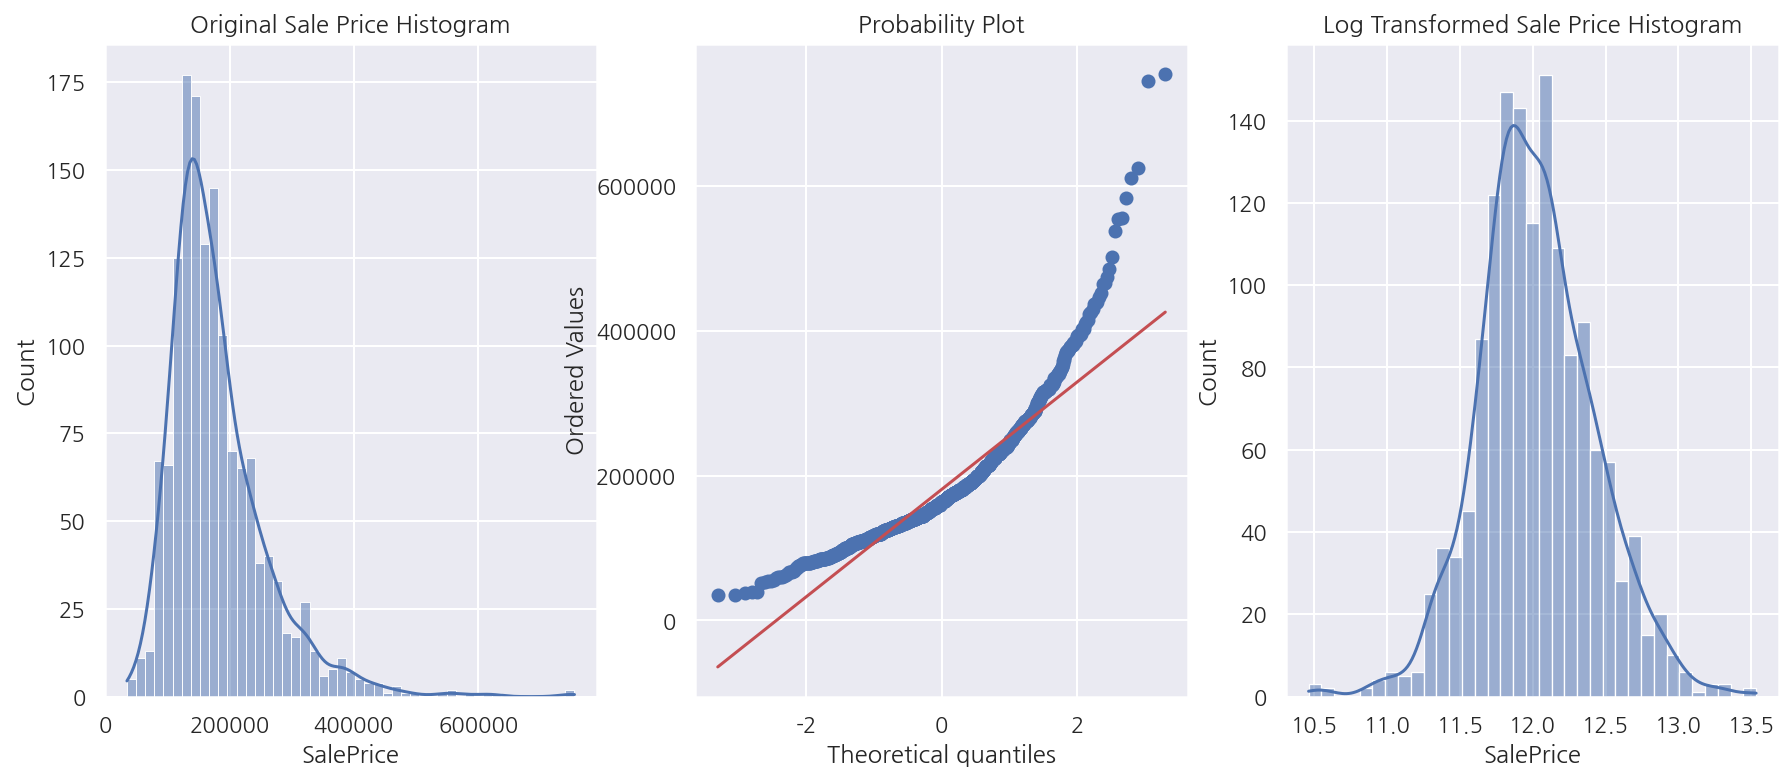

In [18]:
from scipy import stats

fig, axs = plt.subplots(1,3, figsize = (15,6))

sns.histplot(house_df["SalePrice"], ax =axs[0], kde=True)
stats.probplot(house_df["SalePrice"], dist='norm', fit=True, plot=axs[1])
sns.histplot(np.log1p(house_df["SalePrice"]), ax=axs[2], kde=True)

axs[0].set_title("Original Sale Price Histogram")
axs[2].set_title("Log Transformed Sale Price Histogram")

plt.show()

- 종속 변수의 분포는 정규분포 형태를 따르지 않고 로그 변환을 적용하였을 때 정규분포 형태를 띄므로 로그 변환하여 진행한다.

In [19]:
# 피처 제거
house_df.drop( ["Id", "PoolQC", "MiscFeature", "Alley", "Fence"], axis=1, inplace=True )

# 종속 변수 로그 변환
org_SalePrice = house_df["SalePrice"]
house_df["SalePrice"] = np.log1p(house_df["SalePrice"])

# 결측값 대체 - 숫자형
house_df.fillna(house_df.mean(), inplace=True)

# 원-핫 인코딩 - 카테고리형
house_df_ohe = pd.get_dummies(house_df)

- 필요 없는 Id 피처 및 앞서 확인한 결측 1,000건 이상 피처를 제거하였다.


- 종속 변수는 로그 변환하고 나머지 피처 중 숫자형 피처의 결측값은 평균값으로 대체 하였다.


- 카테고리형 피처는 원-핫 인코딩을 진행하였고 원-핫 인코딩은 결측값을 None 컬럼으로 대체한다.

In [20]:
print("원-핫 인코딩 전 shape:", house_df.shape)
print("원-핫 인코딩 후 shape:", house_df_ohe.shape)

원-핫 인코딩 전 shape: (1460, 76)
원-핫 인코딩 후 shape: (1460, 276)


- 원-핫 인코딩으로 인해 피처 갯수는 많이 증가하였다.

## 2.2 회귀 예측/평가

### 2.2.1 기본 예측/평가

**RMSE 함수**

In [21]:
def get_rmse(model):
    pred = model.predict(X_test)
    mse = mean_squared_error(y_test , pred)
    rmse = np.sqrt(mse)
    print(f'{model.__class__.__name__} 로그 변환된 RMSE: {np.round(rmse, 3)}')
    
    return rmse

def get_rmses(models):
    rmses = []
    
    for model in models:
        rmse = get_rmse(model)
        rmses.append(rmse)
    
    return rmses

- 종속 변수를 로그 변환 하였으므로 RMSE는 원래 스케일에서의 RMSLE이다.

In [22]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_features = house_df_ohe.drop('SalePrice',axis=1, inplace=False)
y_target = house_df_ohe['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2, random_state=156)

# LinearRegression, Ridge, Lasso
lr_reg = LinearRegression()
ridge_reg = Ridge()
lasso_reg = Lasso()

lr_reg.fit(X_train, y_train)
ridge_reg.fit(X_train, y_train)
lasso_reg.fit(X_train, y_train)

# 예측 평가
models = [lr_reg, ridge_reg, lasso_reg]
rmses = get_rmses(models)

LinearRegression 로그 변환된 RMSE: 0.132
Ridge 로그 변환된 RMSE: 0.128
Lasso 로그 변환된 RMSE: 0.176


- RMSE는 Ridge가 가장 낮게 나왔고 Lasso가 가장 높게 나타났다.


- 추후 하이퍼 파라미터 튜닝을 진행해서 확인 해보자.

**회귀 계수 시각화 함수**

In [23]:
# 상위, 하위 10개 coefficients 추출
def get_top_bottom_coef(model):
    # coef series
    coef = pd.Series(model.coef_, index = X_features.columns)
    
    coef_high = coef.sort_values(ascending=False).head(10)
    coef_low = coef.sort_values(ascending=False).tail(10)
    return coef_high, coef_low

# 회귀 계수 시각화
def visualize_coefficient(models):
    fig, axs = plt.subplots(3,1, figsize=(24,20))
    fig.tight_layout()
    
    for i, model in enumerate(models):
        coef_high, coef_low = get_top_bottom_coef(model)
        coef_concat = pd.concat( [coef_high , coef_low], axis=0 )
        
        axs[i].set_title(model.__class__.__name__ , size=25, x= 0.9, y= 0.1)
        # axs[i].tick_params(axis="y", direction="in", pad=-120) # tick label 위치 조정
        
        for label in (axs[i].get_xticklabels() + axs[i].get_yticklabels()):
            label.set_fontsize(22)
            
        sns.barplot(x=coef_concat.values, y=coef_concat.index , ax=axs[i])

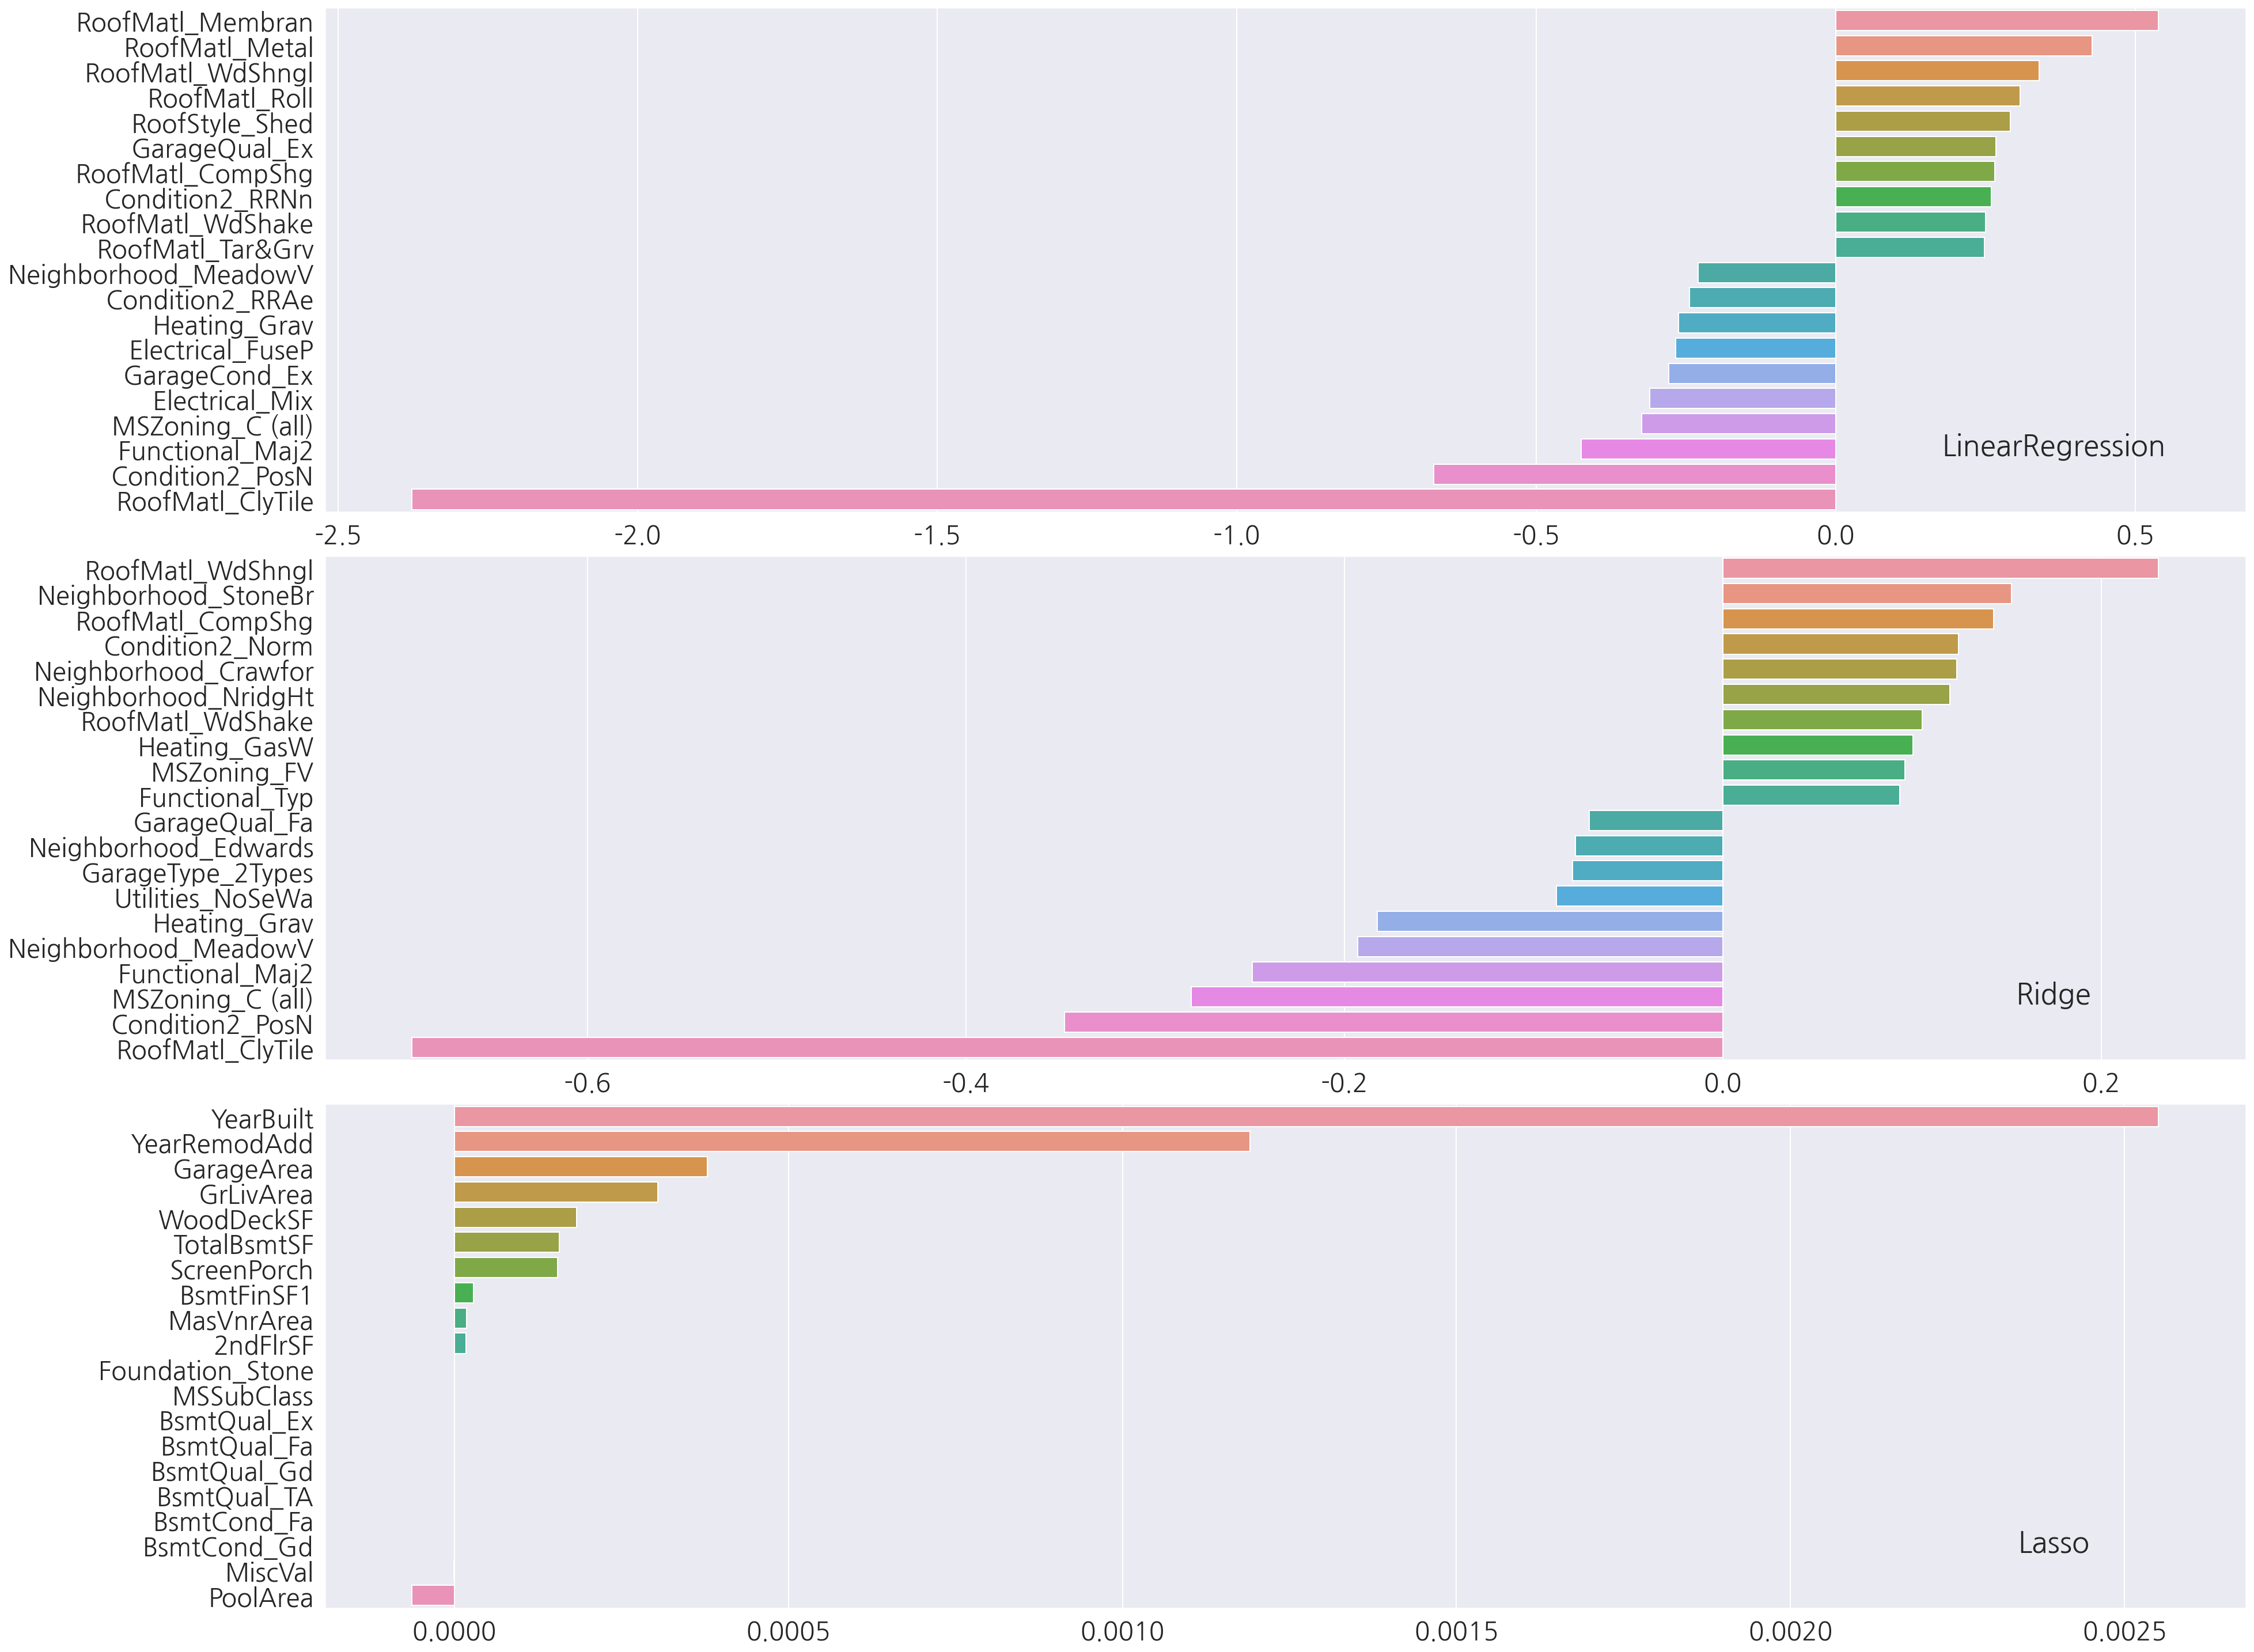

In [24]:
# LinearRegression, Ridge, Lasso
models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)

- 각 모델별 상위, 하위 10개 회귀계수를 확인하였을 때 LinearRegression과 Ridge는 피처 종류가 유사하게 나타났다.


- 반면에 Lasso는 다른 두 모델과 피처 종류도 차이가 있고, x축을 보면 전체적으로 회귀 계수 값이 매우 낮다.


- Lasso 성능의 문제가 train, test 분할에 문제가 있는지 교차 검증을 진행하여 평균 RMSE를 확인해보자.

### 2.2.2 교차 검증

**교차 검증 평균 RMSE 함수**

In [25]:
from sklearn.model_selection import cross_val_score

def get_avg_rmse_cv(models):
    
    for model in models:
        mse_scores = -1*cross_val_score(model, X_features, y_target, 
                                        scoring="neg_mean_squared_error", cv=5)
        rmse_scores = np.sqrt(mse_scores)
        rmse_avg = np.mean(rmse_scores)

        print(f"{model.__class__.__name__} CV RMSE 리스트: {np.round(rmse_scores,3)}")
        print(f"{model.__class__.__name__} CV 평균 RMSE: {rmse_avg:.3f}\n")

In [26]:
# LinearRegression, Ridge, Lasso
lr_reg = LinearRegression()
ridge_reg = Ridge()
lasso_reg = Lasso()

models = [lr_reg, ridge_reg, lasso_reg]
get_avg_rmse_cv(models)

LinearRegression CV RMSE 리스트: [0.136 0.166 0.167 0.111 0.197]
LinearRegression CV 평균 RMSE: 0.156

Ridge CV RMSE 리스트: [0.118 0.156 0.142 0.117 0.188]
Ridge CV 평균 RMSE: 0.144

Lasso CV RMSE 리스트: [0.161 0.204 0.177 0.181 0.265]
Lasso CV 평균 RMSE: 0.198



- 기본 예측/평가에선 train으로 학습 후 test에 대해 평가하였으나 여기선 전체 데이터로 교차 검증 하였음을 인지하자.


- 여전히 Lasso 성능은 다른 두 모델에 비해 떨어진다.


- 이번엔 GridSearchCV를 통해 Ridge와 Lasso의 최적 하이퍼 파라미터를 찾아 적용해보자.

### 2.2.3 GridSearchCV

**하이퍼 파라미터 도출 함수**

In [27]:
from sklearn.model_selection import GridSearchCV

def get_best_params(model, params):
    model_name = model.__class__.__name__
    grid_cv = GridSearchCV(model, param_grid=params, 
                           scoring='neg_mean_squared_error', cv=5)
    
    grid_cv.fit(X_features, y_target)
    best_rmse = np.sqrt(-1* grid_cv.best_score_)
    
    print(f'{model_name} GridSearchCV 최적 평균 RMSE: {np.round(best_rmse, 4)}, 최적 alpha:{grid_cv.best_params_}')
          
    return grid_cv.best_estimator_

In [28]:
# 하이퍼 파라미터
ridge_params = { 'alpha':[0.05, 0.1, 1, 5, 8, 10, 12, 15, 20] }
lasso_params = { 'alpha':[0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1,5, 10] }

# Ridge, Lasso
ridge_reg = Ridge()
lasso_reg = Lasso()

best_ridge = get_best_params(ridge_reg, ridge_params)
best_lasso = get_best_params(lasso_reg, lasso_params)

Ridge GridSearchCV 최적 평균 RMSE: 0.1418, 최적 alpha:{'alpha': 12}
Lasso GridSearchCV 최적 평균 RMSE: 0.142, 최적 alpha:{'alpha': 0.001}


- GridSearchCV를 적용해서 Ridge와 Lasso의 최적 하이퍼 파라미터를 찾았다.


- 최적 하이퍼 파라미터일 때의 평균 RMSE가 이번엔 Ridge와 Lasso가 유사한 값으로 Lasso의 성능이 향상되었다.


- 앞서 교차 검증과 비교하면 Ridge 역시 조금이나마 성능이 향상되었다.

LinearRegression 로그 변환된 RMSE: 0.132
Ridge 로그 변환된 RMSE: 0.125
Lasso 로그 변환된 RMSE: 0.12


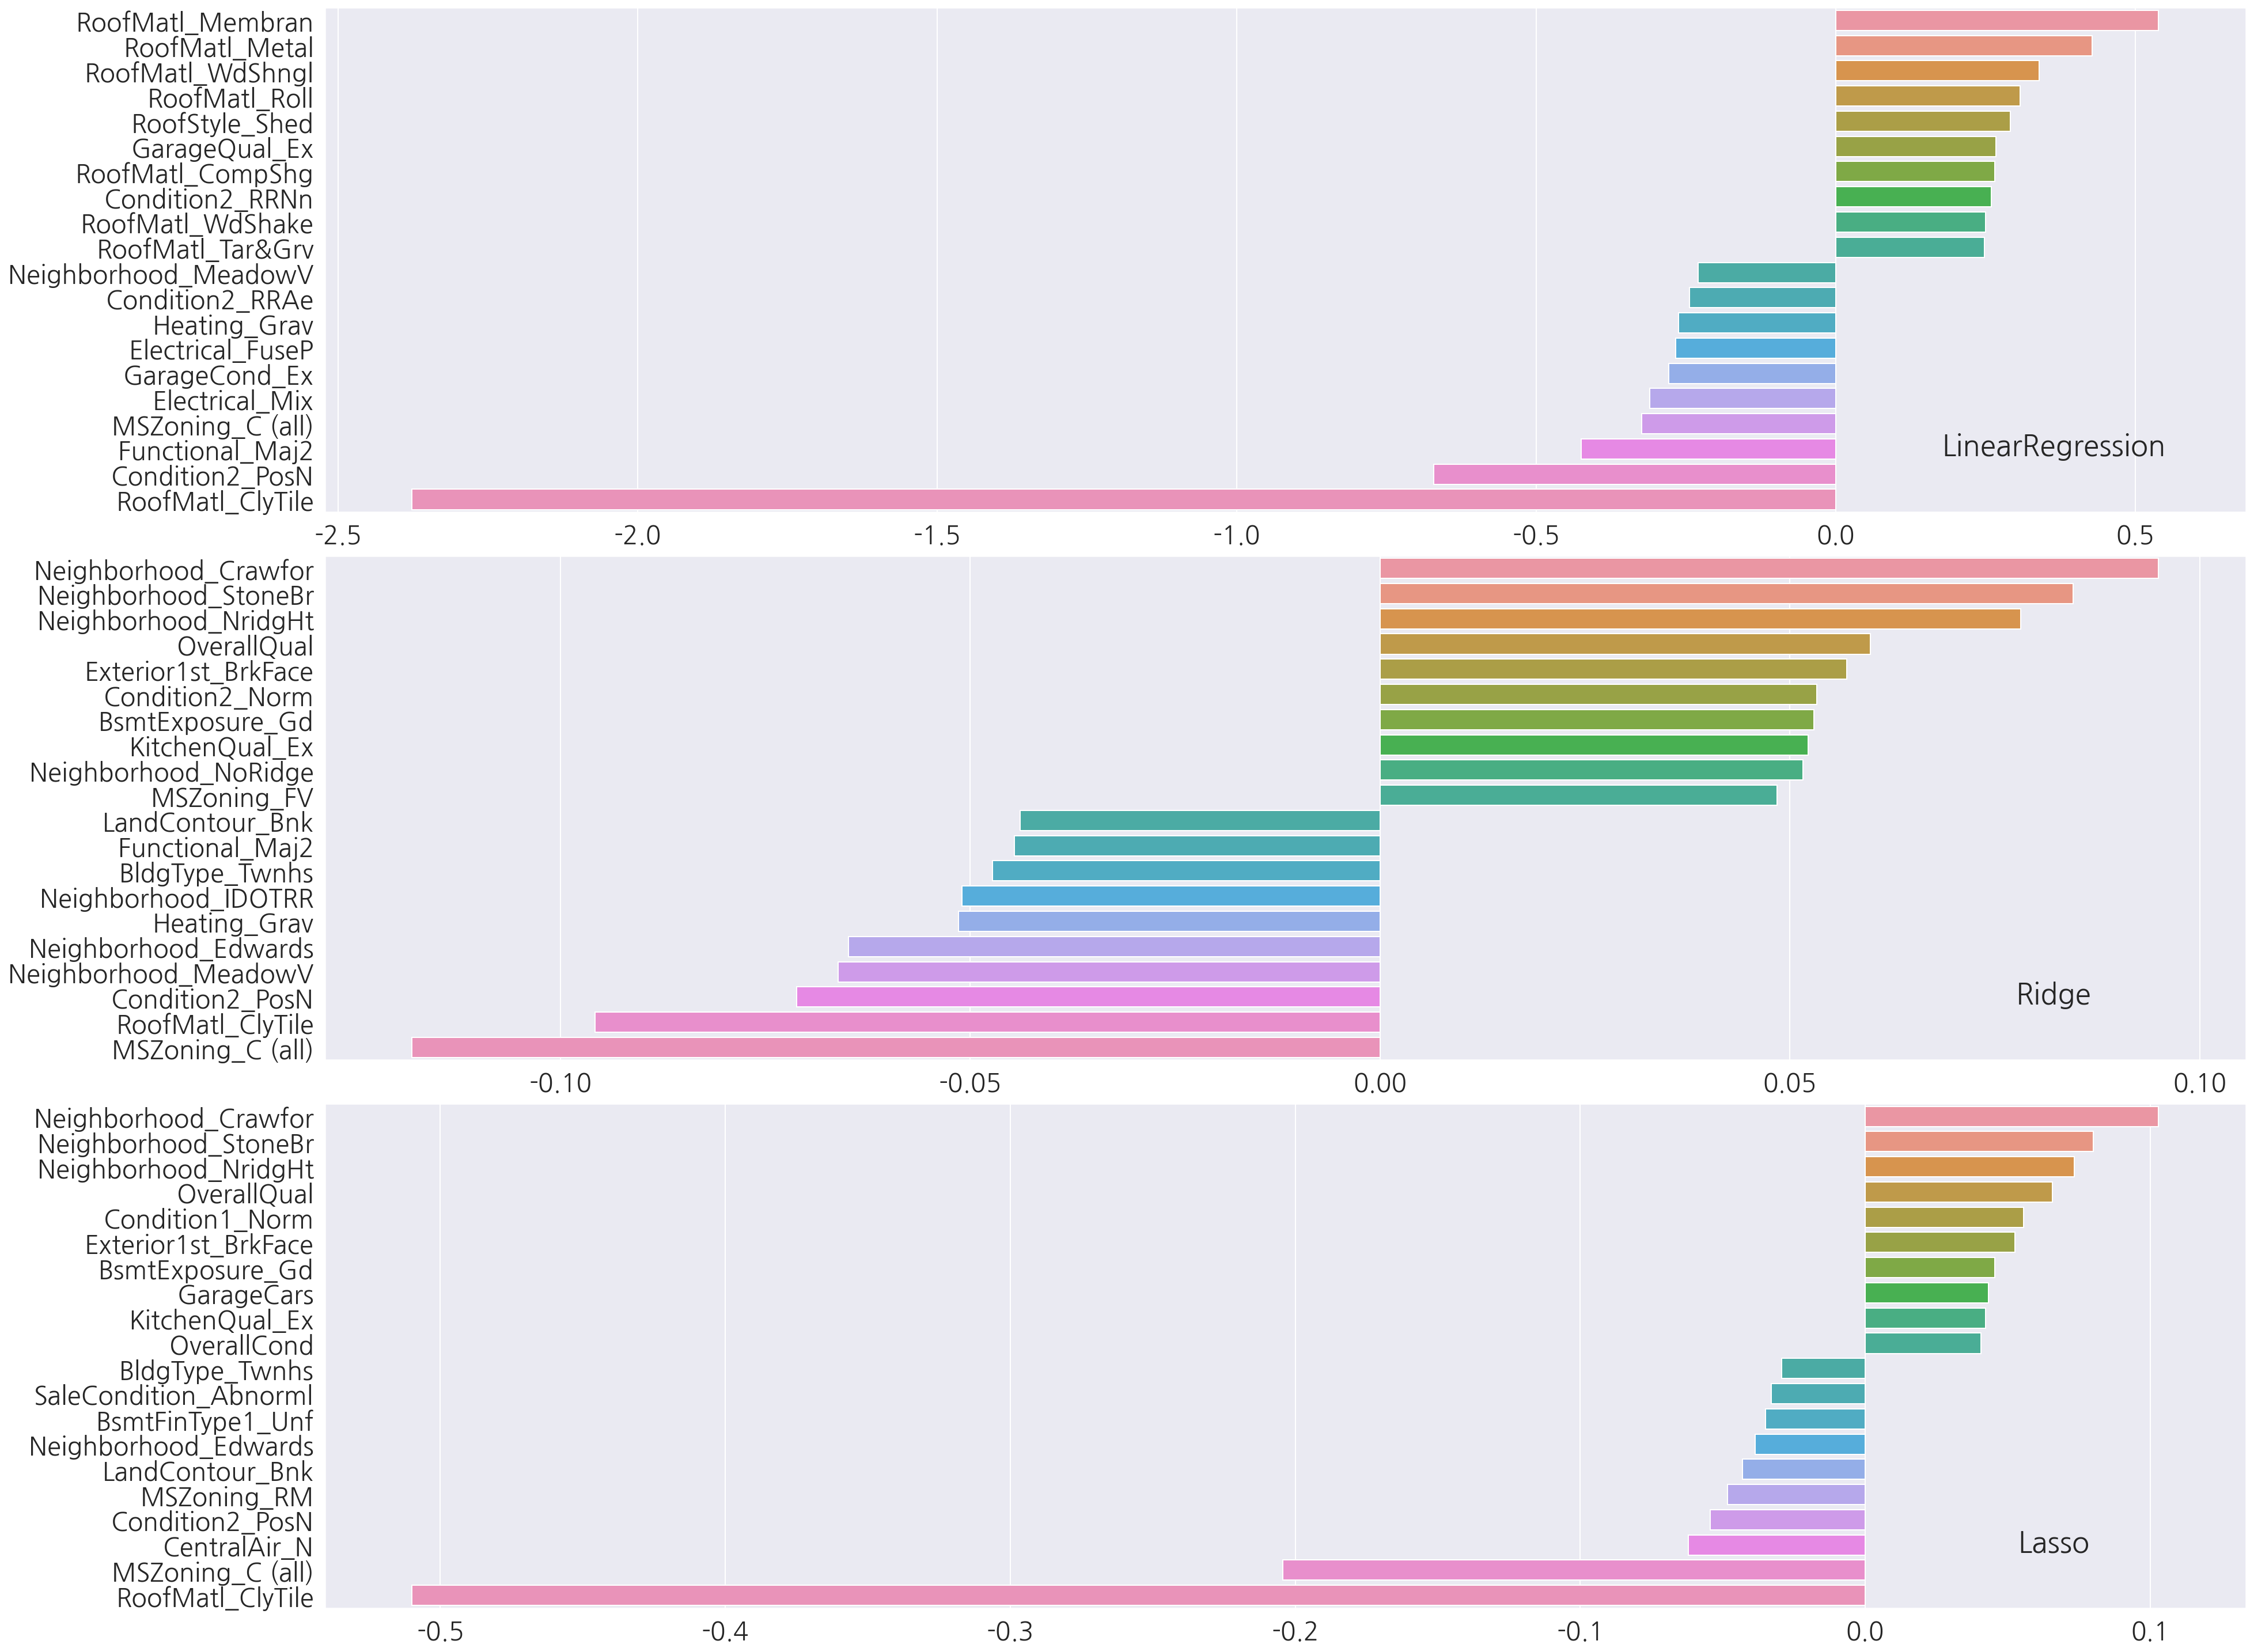

In [29]:
# 최적 하이퍼 파라미터로 Ridge, Lasso 수정
lr_reg = LinearRegression()
ridge_reg = Ridge(alpha=12)
lasso_reg = Lasso(alpha=0.001)

lr_reg.fit(X_train, y_train)
ridge_reg.fit(X_train, y_train)
lasso_reg.fit(X_train, y_train)

# test set RMSE
models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

# 회귀 계수 시각화 
models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)

- 최적 하이퍼 파라미터 적용 후 test 예측 성능도 더 좋아졌다.


- 앞서 Lasso가 상위,하위 피처 종류에 차이가 많았지만 Ridge와 피처 종류도 비슷해졌다.